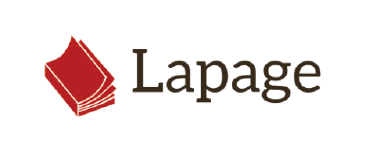

# ANALYSE DES ASSOCIATIONS SUR LES PANIERS CLIENTS CONTENANT AU MOINS UN LIVRE FIGURANT AU TOP 10 DES VENTES

In [1]:
# import librairies needed for project
import datetime as dt
import itertools as it
import math as mt
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import random as rd
import scipy.stats as st
import seaborn as sns

from collections import Counter
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

# import user-created functions
from functions import *

In [2]:
# import sales data
sales = pd.read_csv('transactions.csv', encoding='latin-1')

# import list of top 10 products sold by volume
max_sales = pd.read_csv('tableau2a.csv')

# list is a multi-level index df, so it will show NaNs in some cells of the first row which need to be removed
max_sales.dropna(axis=0, how='any', inplace=True)
max_list = max_sales['product_id_sales'].tolist()

In [3]:
# select all sessions where any top 10 product is present
top_sales = sales.loc[(sales['id_prod']==max_list[0]) | (sales['id_prod']==max_list[1]) | (sales['id_prod']==max_list[2])
                     | (sales['id_prod']==max_list[3]) | (sales['id_prod']==max_list[4])| (sales['id_prod']==max_list[5])
                     | (sales['id_prod']==max_list[6])| (sales['id_prod']==max_list[7]) | (sales['id_prod']==max_list[8])
                     | (sales['id_prod']==max_list[9])]

In [4]:
# count number of products in each session (=basket size) 
sales_nb = top_sales.copy()
sales_nb = sales_nb.groupby(['session_id'])['id_prod'].count().reset_index()
sales_nb.rename(columns={'id_prod': 'basket_size'}, inplace=True)

# add basket size as a column in sales df
sales_multi = pd.merge(sales, sales_nb, how='left', right_on='session_id',left_on='session_id')

# in order to make the running of the algorithm more efficient, we remove from the list of transactions
# all baskets consisting of only 1 item, as no associations would obviously be found in this case anyway
# we select only transactions in sales df containing at least one other product in the basket in addition to a top-10 product
# and remove dummy transactions for product T_0
sales_multi = sales_multi.loc[(sales_multi['basket_size'] > 1) & (sales_multi['id_prod'] != 'T_0')]

# extract only relevant columns from resulting df for association analysis
sales_assoc = sales_multi[['session_id','id_prod']].copy()

# create basket_list column which shows each session's basket as a list of strings 
basket_assoc = sales_assoc.groupby('session_id')['id_prod'].apply(list).reset_index()
basket_assoc.rename(columns={'id_prod': 'basket_list'}, inplace=True)

# the apriori algorithm takes a one-hot encoded or boolean df as input, generated with the transaction encoder function
# the transaction encoder function requires the input baskets to be formatted as a list of lists
# create list of lists from basket_list column
baskets = basket_assoc['basket_list'].copy().to_list()

# create one-hot encoded dataframe from list of baskets
# pass df.astype('bool') as first argument in apriori function otherwise will throw an exception
a = TransactionEncoder()
a_data = a.fit(baskets).transform(baskets)
baskets2 = pd.DataFrame(a_data,columns=a.columns_)
baskets2 = baskets2.replace(False,0)
baskets2 = baskets2.replace(True,1)

# run apriori algorithm on resulting dataframe
# as we are not running the algorithm on the entire sales data but rather on a sampled subset including only the 
# 10 most popular products by volume, there is a risk of losing itemsets that are actually frequent so in order to 
# avoid this, we will set a very low minimum support
# to minimise running time, we only look at itemsets of size max_len = 2
baskets2 = apriori(baskets2.astype('bool'), min_support=0.01, use_colnames=True, verbose=1, low_memory=False, max_len=2)
# baskets2.astype('bool') as baskets2 was one-hot encoded, typecasting not needed if df is boolean

# create association rules table
baskets2_ar = association_rules(baskets2, metric="confidence", min_threshold=0.5, support_only=False)
# baskets2_ar

Processing 2352 combinations | Sampling itemset size 2


In [5]:
# confidence in a rule is calculated by dividing the probability of the items occurring together by the probability
# of the occurrence of the antecedent. Items with confidence of 1 indicate support = antecedent support,
# i.e. both items are always bought together. In this case, the model returns conviction as inf.
# the larger the maximum itemset, the less likely we are to run into such values (we are looking at only 75 product couples 
# here, again, due to memory and running time constraints)

top_supports = baskets2_ar.sort_values(by=['support','conviction'], ascending=False)

In [6]:
# access values from frozen sets for further analysis
top_supports["antecedents"] = top_supports["antecedents"].apply(lambda x: ','
                                                                                  .join(list(x))).astype("unicode")

In [7]:
top_supports_list_tot = top_supports.groupby('consequents')['antecedents'].apply(list).reset_index()

# access values from frozen sets for further analysis
top_supports_list_tot["consequents"] = top_supports_list_tot["consequents"].apply(lambda x: ','
                                                                                  .join(list(x))).astype("unicode")

In [8]:
pd.set_option('display.max_colwidth', None)
top_supports_list_top10 = top_supports_list_tot.loc[top_supports_list_tot['consequents'].isin(max_list)].copy()
top_supports_list_top10.rename(columns={'consequents': 'Products from top 10',
                                        'antecedents':'Frequently bought with'}, inplace=True)
print(top_supports_list_top10.to_csv("top_10_associations.csv", index=False))
top_supports_list_top10

None


,Products from top 10,Frequently bought with
0,1_414,"[1_434, 0_1621, 0_1593]"
1,1_412,[1_400]
2,1_369,"[1_277, 0_1059, 0_1205, 1_141]"
4,1_406,[0_1467]
7,1_425,"[0_1525, 0_1641, 0_2231, 1_504, 1_370]"
8,1_417,"[0_1525, 0_1641, 0_2231, 1_504, 1_370, 1_320, 1_396]"
9,1_407,"[1_433, 0_1205, 1_434, 1_459]"
13,1_498,"[0_1047, 0_1596, 0_1616, 1_456, 1_277, 0_1059, 1_141]"
15,1_413,"[0_1047, 0_1596, 0_1616, 1_456, 1_441]"


In [9]:
freq_buys = top_supports_list_top10["Frequently bought with"].tolist()
freq_buys_merged = list(it.chain(*freq_buys))
freq_buys_list = Counter(freq_buys_merged)
(pd.DataFrame.from_dict(data=freq_buys_list, orient='index').to_csv('AssociationAnalysis.csv', header=False))
freq_buys_list

Counter({'1_434': 2,
         '0_1621': 1,
         '0_1593': 1,
         '1_400': 1,
         '1_277': 2,
         '0_1059': 2,
         '0_1205': 2,
         '1_141': 2,
         '0_1467': 1,
         '0_1525': 2,
         '0_1641': 2,
         '0_2231': 2,
         '1_504': 2,
         '1_370': 2,
         '1_320': 1,
         '1_396': 1,
         '1_433': 1,
         '1_459': 1,
         '0_1047': 2,
         '0_1596': 2,
         '0_1616': 2,
         '1_456': 2,
         '1_441': 1})

#### Les produits 1_141, 1_059, 1_456, 1_370, 0_1205, 0_2231, 1_504, 0_1047, 0_1596, 0_1616, 1_277, 0_1525, 0_1641 et 1_434 sont le plus frequemment achetes avec les produits de notre top 10 en volume (aucun d'entre-eux ne fait lui-meme partie du top 10).
#### Le produit 1_403 est absent de la liste des associations trouvees, ce qu'il a fallu verifier et expliquer.
#### Ce produit est toujours vendu seul (1956 fois) sauf dans 4 sessions ou il est toujours vendu plusieurs fois au meme client dans le meme panier, il n'a donc pas passe le prunage du minimum support a 0.01, meme si celui-ci a ete initialise tres bas pour inclure le maximum de transactions (il est tres peu souvent vendu en panier, et dans tous les rares cas ou il l'est, c'est toujours - entre autres - avec lui-meme).

In [10]:
# on verifie si 1_403 est toujours vendu seul
sales_1_403 = sales.loc[sales['id_prod'] == "1_403"]
sales_1_403.head()

,id_prod,date,session_id,client_id
378,1_403,2021-11-27 17:05:29.270642,s_125917,c_4027
395,1_403,2021-06-10 20:20:47.119410,s_46860,c_4964
439,1_403,2021-08-03 15:52:13.496310,s_70918,c_4372
856,1_403,2022-01-28 23:27:06.042814,s_156661,c_6253
1264,1_403,2022-07-15 10:56:54.590957,s_238704,c_1256


In [11]:
# total number of sales for product 1_403
sales_1_403.shape

(1960, 4)

In [12]:
# number of sessions over which these sales were made
len(sales_1_403['session_id'].unique())

1956

In [13]:
# there are therefore 4 sessions in which 1_403 was sold as part of a basket
# identify session where product 1_403 is in a basket
ver = sales_1_403.loc[sales_1_403['session_id'].duplicated() == True]
ver

,id_prod,date,session_id,client_id
321331,1_403,2021-09-27 09:07:54.808849,s_96271,c_6957
553388,1_403,2021-09-09 22:57:56.628205,s_87497,c_4023
571792,1_403,2021-07-23 01:48:04.032569,s_65901,c_8529
667672,1_403,2022-12-23 01:48:04.032569,s_316029,c_8529


In [14]:
# retrieve session information from sales table
ver2 = sales.loc[(sales['session_id'] == 's_96271') |(sales['session_id'] == 's_87497')|(sales['session_id'] == 's_65901')
                |(sales['session_id'] == 's_316029')]
ver2.shape

(18, 4)

In [15]:
# sort data for final inspection
ver3 = ver2.sort_values(by=['session_id','id_prod'], ascending=False)
ver3

,id_prod,date,session_id,client_id
119219,1_403,2021-09-27 09:21:36.980330,s_96271,c_6957
321331,1_403,2021-09-27 09:07:54.808849,s_96271,c_6957
127318,1_643,2021-09-10 00:08:59.137582,s_87497,c_4023
649159,1_43,2021-09-10 00:13:11.713117,s_87497,c_4023
307055,1_403,2021-09-09 22:59:28.275048,s_87497,c_4023
553388,1_403,2021-09-09 22:57:56.628205,s_87497,c_4023
15103,1_397,2021-09-09 23:48:06.171949,s_87497,c_4023
44415,0_1720,2021-09-09 23:14:44.991880,s_87497,c_4023
274757,0_1704,2021-09-09 23:14:55.220310,s_87497,c_4023
484177,0_1665,2021-09-09 23:27:03.022057,s_87497,c_4023


In [16]:
#### Quand le produit 1_1403 n'est pas achete seul (4 cas sur 1960, soit moins de 0.01 qui est notre minimum support), il est
#### en fait achete avec lui-meme, ce que l'algorithme ne compte pas comme une association a proprement parler
#### (en plus d'etre comme on l'a deja dit tres infrequent) - ce produit n'a donc pas passe l'etape du prunage, malgre
#### le fait qu'il soit en bonne position dans le top 10 des ventes en volume toutes categories confondues.


#### les timings des sessions s_65901 et s_316029 ainsi que le client et les produits achetes sont identiques,
#### seule la date change (+17 mois)
#### compte-tenu du fait que les produits sont des livres, il est curieux que le meme client achete le meme produit 2
#### fois dans la meme session et le rachete ensuite 2 fois plusieurs mois apres, particulierement quand ce client
#### ne fait pas partie de nos clients professionnels => probleme de generation des 
#### donnees? (cf. donnees de ventes manquantes en octobre 2021 pour les produits de classe 1)
#### Il conviendrait de s'assurer en amont de l'integrite des donnees generees par le site de vente en ligne.